# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

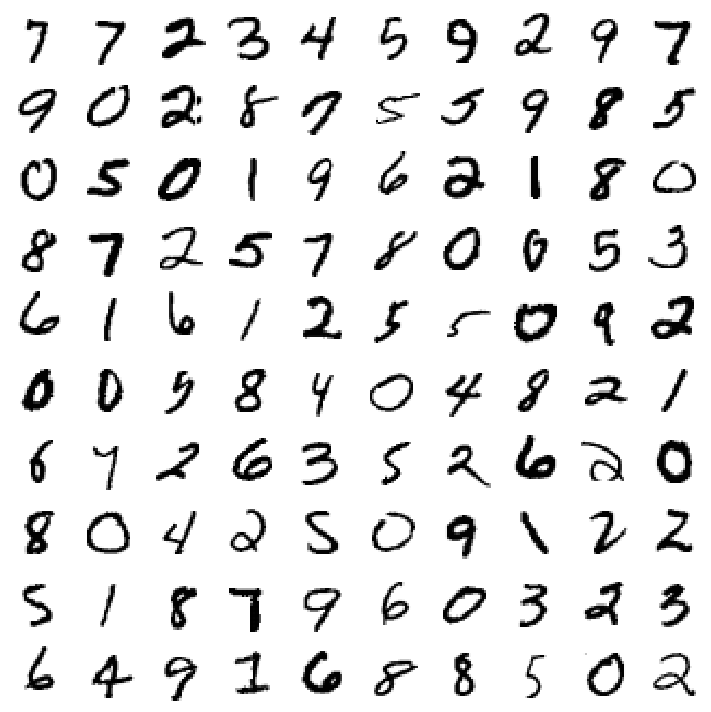

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Compile and train the network (note that this could take a while).

In [3]:
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 [==============================] - 66s 139ms/step - loss: 0.2337 - accuracy: 0.9292 - val_loss: 0.0547 - val_accuracy: 0.9826
Epoch 2/12
469/469 [==============================] - 70s 150ms/step - loss: 0.0821 - accuracy: 0.9755 - val_loss: 0.0396 - val_accuracy: 0.9867
Epoch 3/12
469/469 [==============================] - 67s 142ms/step - loss: 0.0585 - accuracy: 0.9823 - val_loss: 0.0340 - val_accuracy: 0.9890
Epoch 4/12
469/469 [==============================] - 65s 139ms/step - loss: 0.0503 - accuracy: 0.9850 - val_loss: 0.0294 - val_accuracy: 0.9908
Epoch 5/12
 52/469 [==>...........................] - ETA: 56s - loss: 0.0356 - accuracy: 0.9877

KeyboardInterrupt: 

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.029136762022972107
Test accuracy: 0.9921000003814697


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. The images corresponding to the DRIVE test set can be found [here](https://www.dropbox.com/s/zk51wgupimw7jd9/DRIVE.zip?dl=0).

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


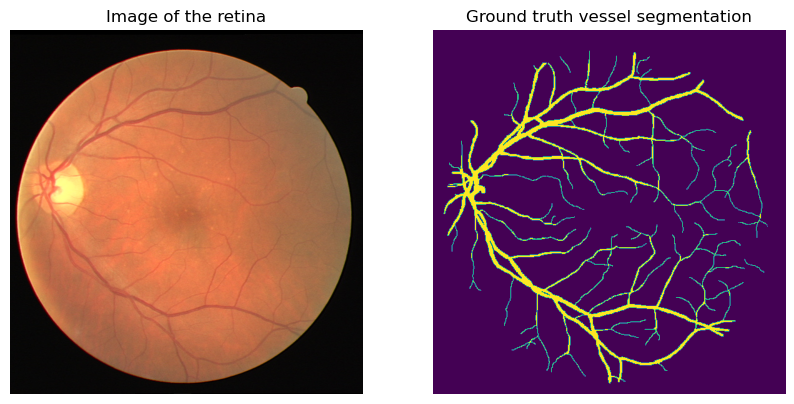

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [67]:
%matplotlib inline
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

sys.path.append('code/')
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = 'data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


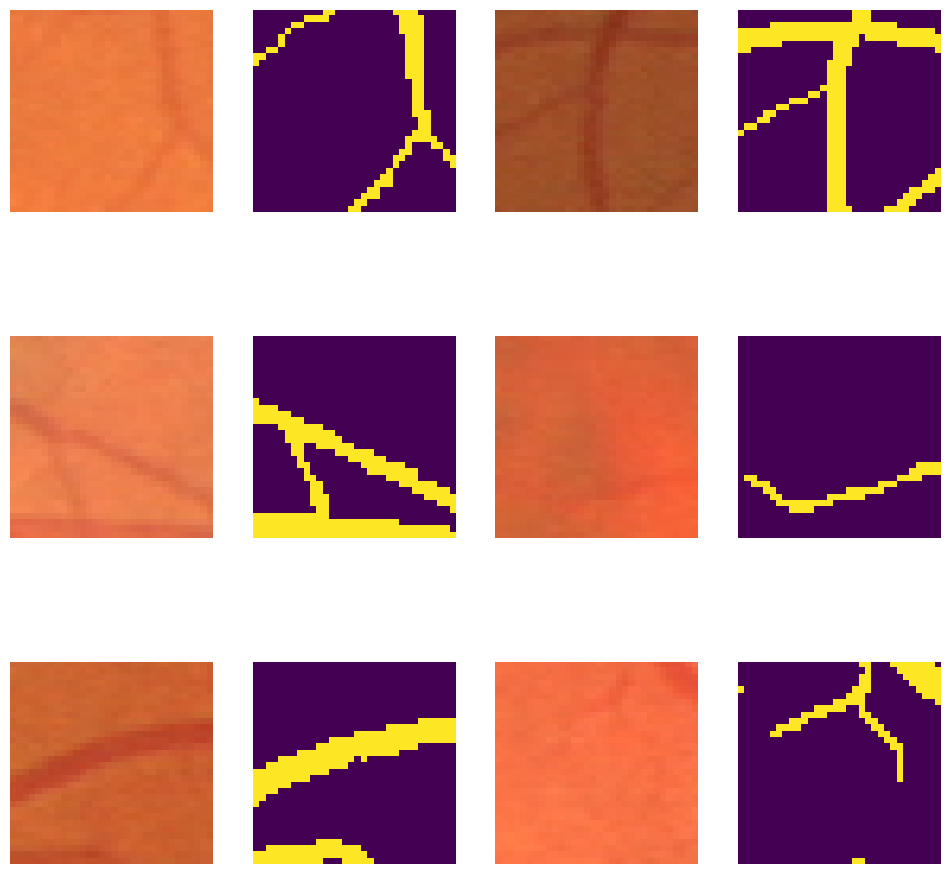

In [68]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [69]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [70]:
import os
import pickle  
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

# Save training history to a file using pickle
history_file_path = 'training_history.pkl'  # Change path as necessary
with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

print(f"Training history saved to {history_file_path}")

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/250
50/50 - 72s - 1s/step - accuracy: 0.8017 - loss: 0.5332 - val_accuracy: 0.9211 - val_loss: 0.4045
Epoch 2/250
50/50 - 47s - 950ms/step - accuracy: 0.9490 - loss: 0.3132 - val_accuracy: 0.9211 - val_loss: 0.2788
Epoch 3/250
50/50 - 49s - 981ms/step - accuracy: 0.9563 - loss: 0.2335 - val_accuracy: 0.9211 - val_loss: 0.2880
Epoch 4/250
50/50 - 47s - 936ms/step - accuracy: 0.9567 - loss: 0.1992 - val_accuracy: 0.9207 - val_loss: 0.3515
Epoch 5/250
50/50 - 45s - 897ms/step - accuracy: 0.9614 - loss: 0.1554 - val_accuracy: 0.9211 - val_loss: 0.3559
Epoch 6/250
50/50 - 46s - 930ms/step - accuracy: 0.9596 - loss: 0.1479 - val_accuracy: 0.9211 - val_loss: 0.4367
Epoch 7/250
50/50 - 57s - 1s/step - accuracy: 0.9606 - loss: 0.1502 - val_accuracy: 0.7688 - val_loss: 0.5644
Epoch 8/250
50/50 - 69s - 1s/step - accuracy: 0.9537 - loss: 0.1525 - val_accuracy: 0.9296 - val_loss: 0.2476
Epoch 9/250
50/50 - 60s - 1s/step - accuracy: 0.9588 - loss: 0.1395 - v

### Visualizing the segmentation results

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


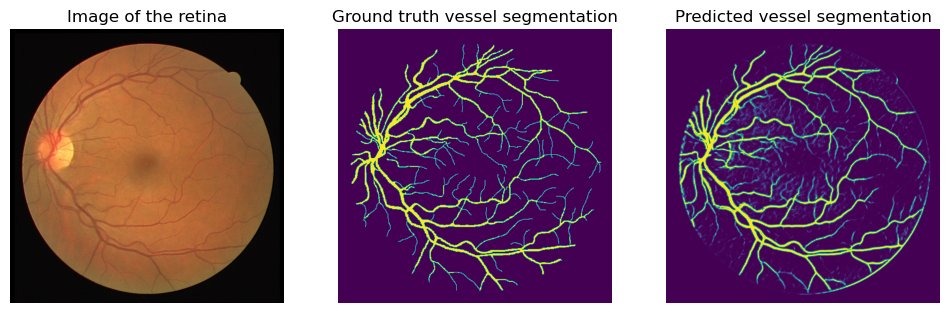

In [71]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>



## Anwser

##### The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1,179,776 parameters. What do these parameters correspond to?

The parameters given by `model.summary()` correspond to weights and biases that the model learns during the training process. The number of the parameters depends on the size and amount of filters used in a specific layer. For the first convolutional layer we have 320 parameters because:

* There are 32 filters (last value of the layer shape)
* the filters are 3x3x1 in dimension so there are 9 weights per filter
* There are 32 biases, one for each filter

This leads to 32 x 9 + 32 = 320 parameters.

for the first fully connected layer we do the same type of calculation:

* The layer before the first fully connected layer has 9,216 inputs.
* The first fully connected layer has 128 neurons.
* Each neuron has a bias so there are 128 biases.

since each input is connected to a neuron (hence fully connected layer) the total number of parameters is:

9,216 x 128 + 128 = 1,179,776 parameters

##### What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?

1) For a convolution layer the general expression for the number of parameters is dependent on several factors namely, filter size (FxF), number of input channels (RGB or greyscale, C), number of filters (N) and the biases of the filters (1 per filter). This leads to the following expression:

$N_{parameters} = (F*F*C+1)*N_{filters}$

2) For the fully connected layer this expression is slightly different here the number of parameters is dependent on: the number of inputs (I), the number of neurons or outputs (O) and the biases of these outputs (also O).
This leads to:

$N_{parameters} = (I*O)+O$

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

In [15]:
# DEFINE NETWORK
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D

model_c = Sequential()
model_c.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_c.add(Conv2D(64, (3, 3), activation='relu'))
model_c.add(MaxPooling2D(pool_size=(2, 2)))
model_c.add(Dropout(0.25))
model_c.add(Conv2D(128, (12, 12), activation='relu'))
model_c.add(Dropout(0.5))
model_c.add(Conv2D(10, (1, 1), activation='softmax'))
model_c.add(GlobalAveragePooling2D())

model_c.summary()



c:\Users\dirk7\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 1, 1, 128)      │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 1, 1, 10)       │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 10)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# COMPILE AND TRAIN NETWORK
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

print(x_test.shape, y_test.shape)

model_c.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model_c.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score_c = model_c.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score_c[0])
print('Test accuracy:', score_c[1])

(10000, 28, 28, 1) (10000, 10)
Epoch 1/12
469/469 [==============================] - 288s 612ms/step - loss: 0.2257 - accuracy: 0.9315 - val_loss: 0.0493 - val_accuracy: 0.9837
Epoch 2/12
469/469 [==============================] - 289s 616ms/step - loss: 0.0819 - accuracy: 0.9754 - val_loss: 0.0403 - val_accuracy: 0.9859
Epoch 3/12
469/469 [==============================] - 283s 602ms/step - loss: 0.0612 - accuracy: 0.9814 - val_loss: 0.0328 - val_accuracy: 0.9896
Epoch 4/12
469/469 [==============================] - 265s 564ms/step - loss: 0.0491 - accuracy: 0.9848 - val_loss: 0.0334 - val_accuracy: 0.9892
Epoch 5/12
469/469 [==============================] - 264s 563ms/step - loss: 0.0412 - accuracy: 0.9873 - val_loss: 0.0323 - val_accuracy: 0.9898
Epoch 6/12
469/469 [==============================] - 280s 598ms/step - loss: 0.0368 - accuracy: 0.9883 - val_loss: 0.0292 - val_accuracy: 0.9912
Epoch 7/12
469/469 [==============================] - 275s 586ms/step - loss: 0.0319 - accura

The fully convolutional network gives a test loss of 0,03 and a test accuracy of 0.99, similar to the model with a dense layer which gives a test loss of 0.029 and a test accuracy of 0.99. This shows that the 2 models perform similarly.

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

## Answer

##### What is the role of the skip connections in the U-Net neural network architecture?

The skip connections have two roles in the U-Net:

* Fine-grained detail recovery
The role of skip connections in the U-Net architecture is to recover fine-grained details in the prediction. During the encoding phase, the spatial resolution is reduced, losing detailed information about the original input. Skip connections link the corresponding layers in the encoder and decoder, allowing the decoder to access high-resolution features from the encoder. This enables the network to keep fine details and make more accurate, pixel-wise predictions in the final output.

* Vanishing gradient prevention
Skip connections help prevent the vanishing gradient problem, which can occur in deeper networks. By allowing the gradient to flow directly from deeper layers to shallower layers during backpropagation, skip connections maintain stronger gradients. This helps the network to train more effectively. Without them, the network might struggle to update its earlier layers, leading to poor performance.

##### Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?

Yes, it is possible to train the same architecture without skip connections. However, the expected result would be less performance.

Without skip connections, the model would lose the ability to pass the fine-grained details from the encoder to the decoder. As a result, the model may generate predictions that are blurred or less accurate. This is especially a problem in tasks that require pixel-level accuracy, like segmentation.
Additionally, the absence of skip connections may result in the vanishing gradient problem, making it harder for the network to train effectively. This can lead to slower convergence or even not training at all.


## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>


Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

Images shape: (20, 584, 565, 3)


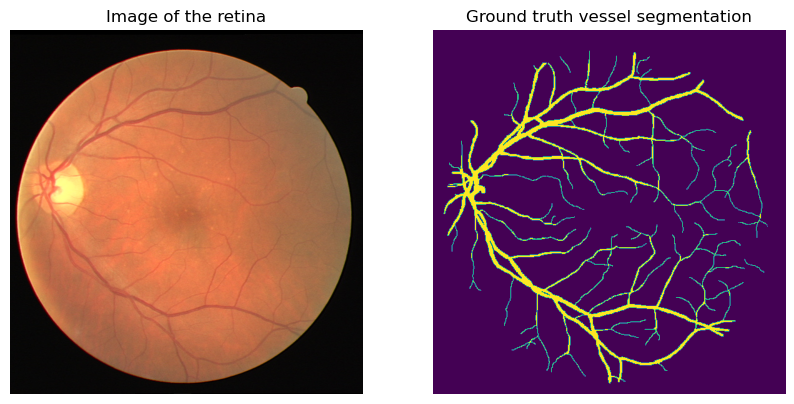

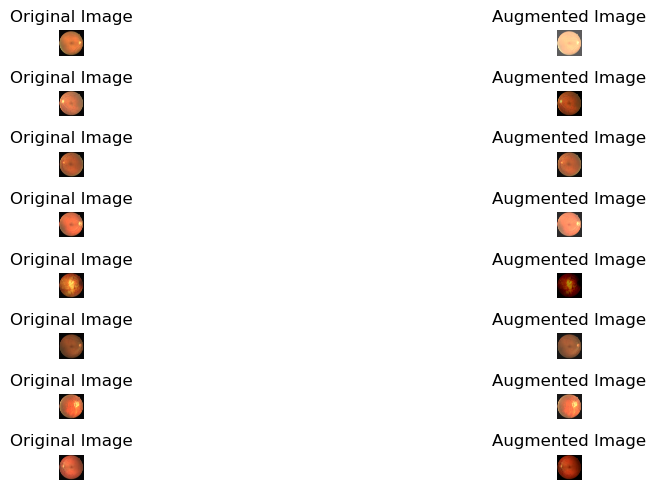

Patches shape: (16, 32, 32, 3)


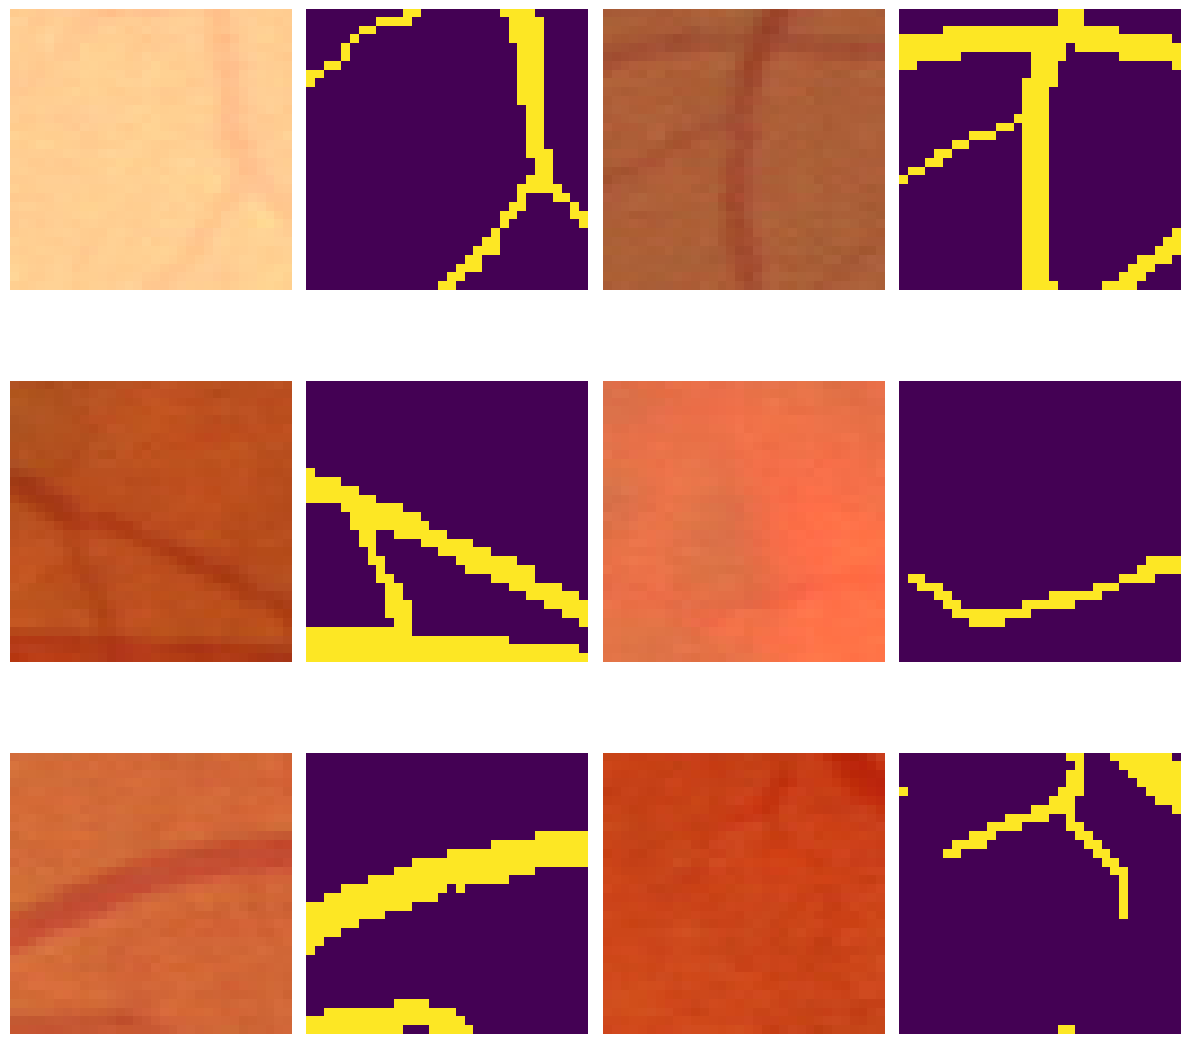

In [72]:
%matplotlib inline
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import random

sys.path.append('code/')
from unet_utils import load_data, extract_patches

# Load data from the DRIVE dataset
data_folder = 'data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# Print the shape of the image dataset
print("Images shape:", images.shape)

# Visualize a sample image and its corresponding segmentation
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])
plt.show()

train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

def random_brightness(image, max_delta=0.4):
    delta = random.uniform(-max_delta, max_delta)
    augmented_image = np.clip(image + delta, 0, 1)  
    return augmented_image

augmented_train_images = np.array([random_brightness(img) for img in train_images])

# Visualize original and augmented images
num_samples = 8  # Number of samples to visualize
plt.figure(figsize=(15, 5))

for i in range(num_samples):
    # Original images
    plt.subplot(num_samples, 2, i * 2 + 1)
    plt.title("Original Image")
    plt.axis('off')
    plt.imshow(train_images[i])
    
    # Augmented images
    plt.subplot(num_samples, 2, i * 2 + 2)
    plt.title("Augmented Image")
    plt.axis('off')
    plt.imshow(augmented_train_images[i])

plt.tight_layout()
plt.show()

patch_size = (32, 32)
patches_per_im = 200

patches, patches_segmentations = extract_patches(augmented_train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print("Patches shape:", patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i + 5])  
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i + 5][:, :, 0])

plt.tight_layout()
plt.show()


In [73]:

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [74]:
import os
import numpy as np
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

X_train_aug, y_train_aug = np.expand_dims(augmented_train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print("Training image shape:", X_train_aug.shape)
print("Training segmentation shape:", y_train_aug.shape)

# Hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
patches_per_im = 200
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with the data generator, and save the training history
history = model.fit(datagenerator(augmented_train_images, train_segmentations, patch_size, patches_per_im, batch_size),
                    validation_data=(val_images, val_segmentations),
                    steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                    callbacks=[early_stopping])

history_file_path = 'training_history1.pkl' 
with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

print(f"Training history saved to {history_file_path}")


Training image shape: (1, 584, 565, 3)
Training segmentation shape: (1, 584, 565, 1)
Epoch 1/250
50/50 - 73s - 1s/step - accuracy: 0.8047 - loss: 0.5540 - val_accuracy: 0.9211 - val_loss: 0.4376
Epoch 2/250
50/50 - 52s - 1s/step - accuracy: 0.9333 - loss: 0.3420 - val_accuracy: 0.6632 - val_loss: 0.8565
Epoch 3/250
50/50 - 51s - 1s/step - accuracy: 0.9403 - loss: 0.2703 - val_accuracy: 0.9211 - val_loss: 0.2700
Epoch 4/250
50/50 - 52s - 1s/step - accuracy: 0.9456 - loss: 0.2125 - val_accuracy: 0.9202 - val_loss: 0.3106
Epoch 5/250
50/50 - 52s - 1s/step - accuracy: 0.9475 - loss: 0.1810 - val_accuracy: 0.9208 - val_loss: 0.2967
Epoch 6/250
50/50 - 52s - 1s/step - accuracy: 0.9492 - loss: 0.1661 - val_accuracy: 0.9220 - val_loss: 0.2479
Epoch 7/250
50/50 - 56s - 1s/step - accuracy: 0.9522 - loss: 0.1491 - val_accuracy: 0.9361 - val_loss: 0.1793
Epoch 8/250
50/50 - 55s - 1s/step - accuracy: 0.9502 - loss: 0.1469 - val_accuracy: 0.9244 - val_loss: 0.2365
Epoch 9/250
50/50 - 52s - 1s/step -

With B-spline


Images shape: (20, 584, 565, 3)


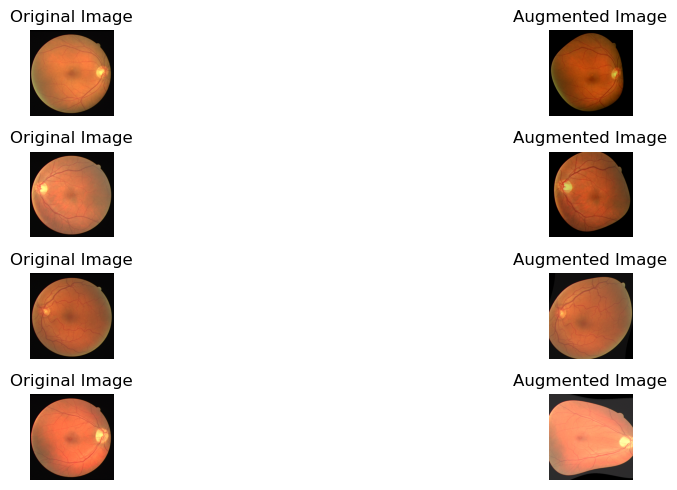

Patches shape: (16, 32, 32, 3)


In [75]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import random
import gryds  
from unet_utils import load_data, extract_patches

=data_folder = 'data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

print("Images shape:", images.shape)

# Split into training and validation datasets
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# Function for random brightness augmentation
def random_brightness(image, max_delta=0.4):
    delta = random.uniform(-max_delta, max_delta)
    augmented_image = np.clip(image + delta, 0, 1)  
    return augmented_image

# Function for B-spline geometric augmentation using gryds
def b_spline_augmentation(image, grid_size=(3, 3), max_deformation=0.1):
    random_grid = np.random.rand(2, grid_size[0], grid_size[1])
    random_grid -= 0.5  
    random_grid /= 5    
    transformed_channels = []

    for channel in range(image.shape[2]):
        bspline = gryds.BSplineTransformation(random_grid)
        interpolator = gryds.Interpolator(image[:, :, channel])
        transformed_channel = interpolator.transform(bspline)
        transformed_channels.append(transformed_channel)
    transformed_image = np.stack(transformed_channels, axis=-1)

    return np.clip(transformed_image, 0, 1)  # Ensure values are in [0, 1]

# Combined augmentation function
def augment_image(image):
    bright_img = random_brightness(image)
    return b_spline_augmentation(bright_img)

augmented_train_images = np.array([augment_image(img) for img in train_images])
data_2 = augmented_train_images

# Visualize original and augmented images
num_samples = 4  # Number of samples to visualize
plt.figure(figsize=(15, 5))

for i in range(num_samples):
    plt.subplot(num_samples, 2, i * 2 + 1)
    plt.title("Original Image")
    plt.axis('off')
    plt.imshow(train_images[i])
    plt.subplot(num_samples, 2, i * 2 + 2)
    plt.title("Augmented Image")
    plt.axis('off')
    plt.imshow(data_2[i])

plt.tight_layout()
plt.show()

patch_size = (32, 32)
patches_per_im = 200

patches, patches_segmentations = extract_patches(data_2, train_segmentations, patch_size, patches_per_im=1, seed=7)

print("Patches shape:", patches.shape)


In [76]:

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [77]:
import os
import numpy as np
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Prepare augmented data
X_train_aug = np.expand_dims(data_2, axis=0)  # Use data_2 directly
y_train_aug = np.expand_dims(train_segmentations, axis=0)  

print("Training image shape:", X_train_aug.shape)
print("Training segmentation shape:", y_train_aug.shape)

depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
patches_per_im = 200  
steps_per_epoch = int(np.ceil((patches_per_im * len(data_2)) / batch_size)) 

model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with the data generator using augmented data
history = model.fit(datagenerator(data_2, train_segmentations, patch_size, patches_per_im, batch_size),
                    validation_data=(val_images, val_segmentations),
                    steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                    callbacks=[early_stopping])

history_file_path = 'training_history2.pkl'  
with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

print(f"Training history saved to {history_file_path}")

Training image shape: (1, 16, 584, 565, 3)
Training segmentation shape: (1, 16, 584, 565, 1)
Epoch 1/250
50/50 - 81s - 2s/step - accuracy: 0.7150 - loss: 0.6305 - val_accuracy: 0.9211 - val_loss: 0.5176
Epoch 2/250
50/50 - 54s - 1s/step - accuracy: 0.8895 - loss: 0.4807 - val_accuracy: 0.9211 - val_loss: 0.3866
Epoch 3/250
50/50 - 54s - 1s/step - accuracy: 0.9011 - loss: 0.3823 - val_accuracy: 0.9211 - val_loss: 0.3125
Epoch 4/250
50/50 - 56s - 1s/step - accuracy: 0.9053 - loss: 0.3244 - val_accuracy: 0.9211 - val_loss: 0.2773
Epoch 5/250
50/50 - 55s - 1s/step - accuracy: 0.9032 - loss: 0.3083 - val_accuracy: 0.9211 - val_loss: 0.2646
Epoch 6/250
50/50 - 57s - 1s/step - accuracy: 0.8980 - loss: 0.3149 - val_accuracy: 0.9211 - val_loss: 0.2723
Epoch 7/250
50/50 - 56s - 1s/step - accuracy: 0.9003 - loss: 0.3049 - val_accuracy: 0.9211 - val_loss: 0.2960
Epoch 8/250
50/50 - 56s - 1s/step - accuracy: 0.9020 - loss: 0.3027 - val_accuracy: 0.9211 - val_loss: 0.2828
Epoch 9/250
50/50 - 57s - 1

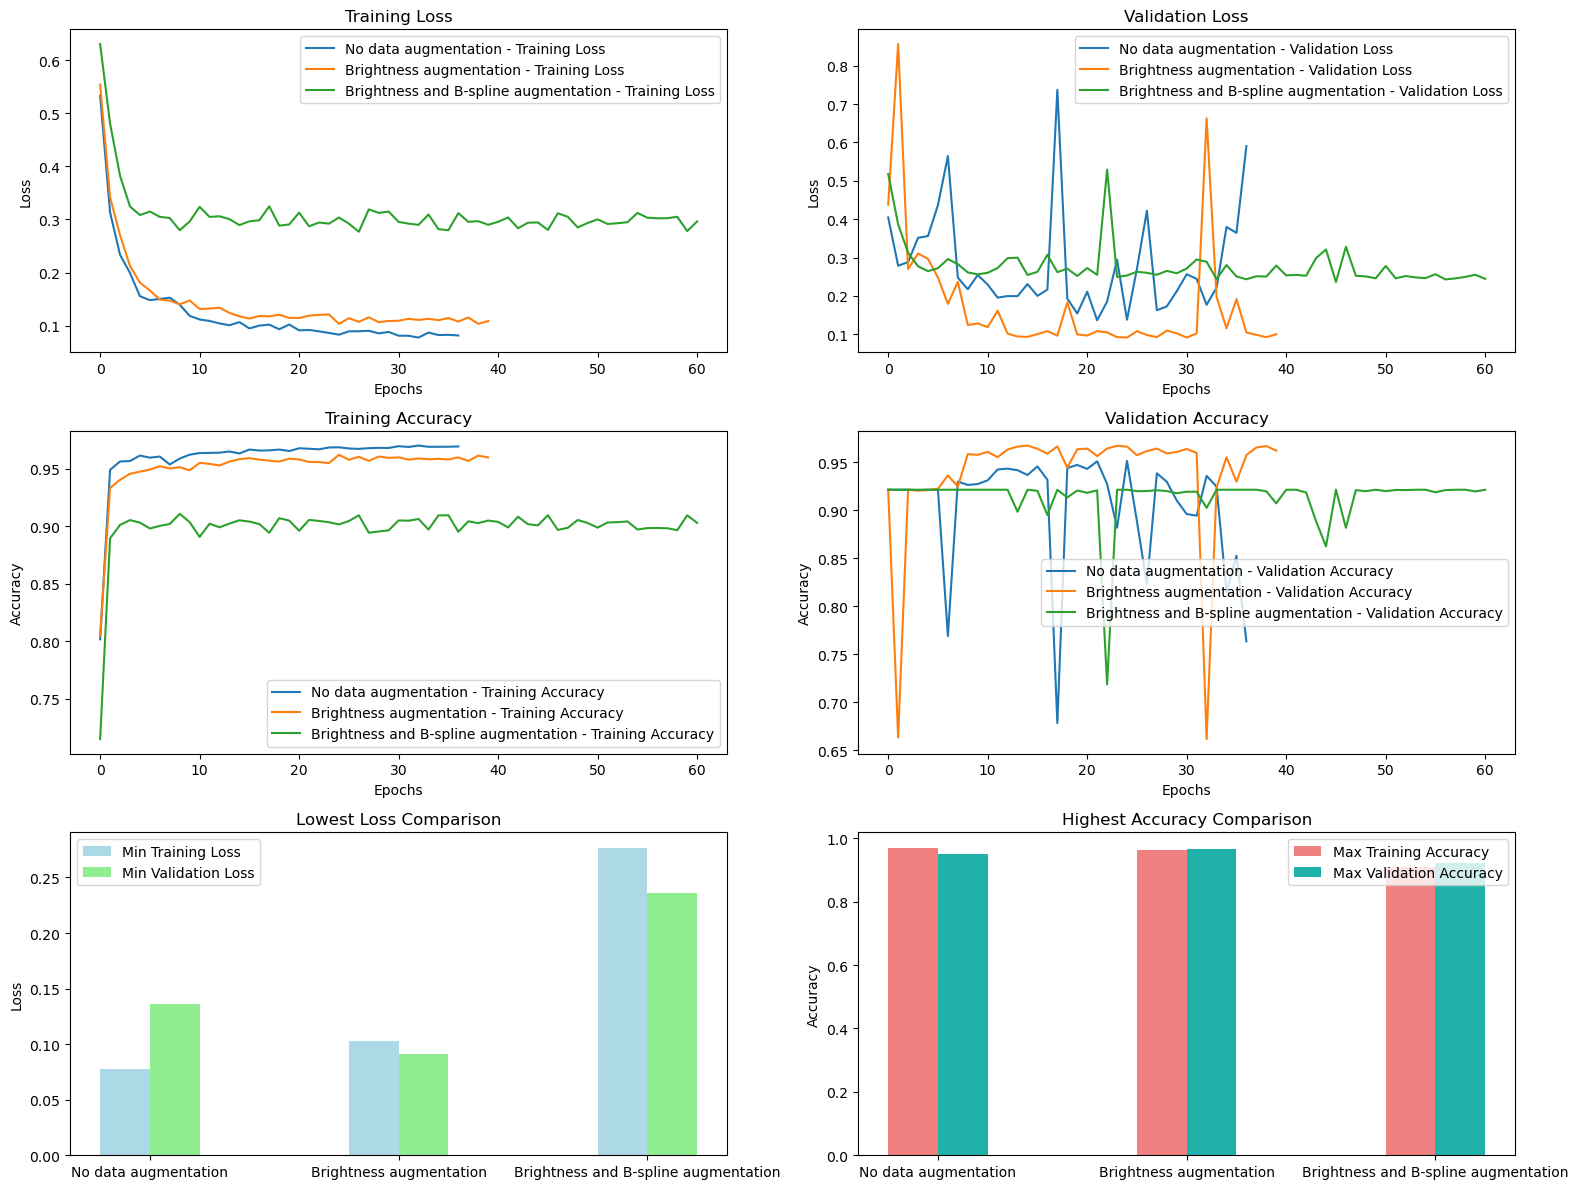

Combined training history plot saved to combined_training_history_plot.png


In [83]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open('training_history.pkl', 'rb') as file:
    training_history = pickle.load(file)

with open('training_history1.pkl', 'rb') as file:
    training_history1 = pickle.load(file)

with open('training_history2.pkl', 'rb') as file:
    training_history2 = pickle.load(file)


def plot_multiple_histories_with_min_max(histories, labels, save_path='combined_training_history_plot.png'):
    """Plot training and validation loss/accuracy separately and show min/max for losses and accuracies."""
    plt.figure(figsize=(16, 12))

    plt.subplot(3, 2, 1)
    for history, label in zip(histories, labels):
        epochs = range(len(history['loss'])) 
        plt.plot(epochs, history['loss'], label=f'{label} - Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    for history, label in zip(histories, labels):
        epochs = range(len(history['val_loss']))  
        plt.plot(epochs, history['val_loss'], label=f'{label} - Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy for all histories
    plt.subplot(3, 2, 3)
    for history, label in zip(histories, labels):
        epochs = range(len(history['accuracy']))  # Adjust epochs length for each history
        plt.plot(epochs, history['accuracy'], label=f'{label} - Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 2, 4)
    for history, label in zip(histories, labels):
        epochs = range(len(history['val_accuracy']))  
        plt.plot(epochs, history['val_accuracy'], label=f'{label} - Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    min_training_losses = [np.min(history['loss']) for history in histories]
    min_val_losses = [np.min(history['val_loss']) for history in histories]
    max_training_accuracies = [np.max(history['accuracy']) for history in histories]
    max_val_accuracies = [np.max(history['val_accuracy']) for history in histories]

    plt.subplot(3, 2, 5)
    bar_width = 0.2
    labels_pos = np.arange(len(labels))

    plt.bar(labels_pos, min_training_losses, bar_width, label='Min Training Loss', color='lightblue')
    plt.bar(labels_pos + bar_width, min_val_losses, bar_width, label='Min Validation Loss', color='lightgreen')
    plt.xticks(labels_pos + bar_width / 2, labels)
    plt.title('Lowest Loss Comparison')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.bar(labels_pos, max_training_accuracies, bar_width, label='Max Training Accuracy', color='lightcoral')
    plt.bar(labels_pos + bar_width, max_val_accuracies, bar_width, label='Max Validation Accuracy', color='lightseagreen')
    plt.xticks(labels_pos + bar_width / 2, labels)
    plt.title('Highest Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Combined training history plot saved to {save_path}")

histories = [training_history, training_history1, training_history2]
labels = ['No data augmentation', 'Brightness augmentation', 'Brightness and B-spline augmentation']

# Plot the histories
plot_multiple_histories_with_min_max(histories, labels)

